In [ ]:
!pip install -q pyspark==3.1.2

In [ ]:
# Install library for finding Spark
!pip install -q findspark

In [ ]:
# import all required packages
from pyspark.sql.types import *
import datetime
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
customschema = StructType([
StructField("Date", StringType(), True)
,StructField("Location", StringType(), True)
,StructField("MinTemp", DoubleType(), True)
,StructField("MaxTemp", DoubleType(), True)
,StructField("Rainfall", DoubleType(), True)
,StructField("Evaporation", DoubleType(), True)
,StructField("Sunshine", DoubleType(), True)
,StructField("WindGustDir", StringType(), True)
,StructField("WindGustSpeed", DoubleType(), True)
,StructField("WindDir9am", StringType(), True)
,StructField("WindDir3pm", StringType(), True)
,StructField("WindSpeed9am", DoubleType(), True)
,StructField("WindSpeed3pm", DoubleType(), True)
,StructField("Humidity9am", DoubleType(), True)
,StructField("Humidity3pm", DoubleType(), True)
,StructField("Pressure9am", DoubleType(), True)
,StructField("Pressure3pm", DoubleType(), True)
,StructField('Cloud9am', DoubleType(), True)
,StructField('Cloud3pm', DoubleType(), True)
,StructField('Temp9am', DoubleType(), True)
,StructField('Temp3pm', DoubleType(), True)
,StructField('RainToday', StringType(), True)
,StructField('RainTomorrow', StringType(), True)
])

df1 = spark.read.format("csv")\
           .option("delimiter", ",")\
           .option("header", "true")\
           .option("multiLine","true")\
           .option("mode","PERMISSIVE")\
           .option("ignoreLeadingWhiteSpace","true")\
           .option("ignoreTrailingWhiteSpace","true")\
           .option("parserLib","UNIVOCITY")\
           .schema(customschema)\
           .load("gdrive/My Drive/Colab Notebooks/Dataset/weatherAUS.csv")

In [ ]:
df1.cache()
df1.show(10)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|       null|    null|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|    null|   16.9|   21.8|       No|          No|
|2008-12-02|

#### Total number of rows and columns in your data ?

In [ ]:
print(f'number of row, number of columns = {(df1.count(), len(df1.columns))}')

number of row, number of columns = (145460, 23)


#### Explore individual columns to understand the data by applying group by , filter and statistical functions for numerical columns and describe the insights 

In [ ]:
df1.describe().show()

+-------+----------+--------+-----------------+------------------+-----------------+------------------+------------------+-----------+------------------+----------+----------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+------------+
|summary|      Date|Location|          MinTemp|           MaxTemp|         Rainfall|       Evaporation|          Sunshine|WindGustDir|     WindGustSpeed|WindDir9am|WindDir3pm|      WindSpeed9am|      WindSpeed3pm|       Humidity9am|      Humidity3pm|       Pressure9am|       Pressure3pm|          Cloud9am|          Cloud3pm|           Temp9am|           Temp3pm|RainToday|RainTomorrow|
+-------+----------+--------+-----------------+------------------+-----------------+------------------+------------------+-----------+------------------+----------+----------+------------------+------------------+-----------

In [ ]:
df1.groupBy('WindGustDir').count().orderBy('WindGustDir').sort('count', ascending = False).show()

+-----------+-----+
|WindGustDir|count|
+-----------+-----+
|         NA|10326|
|          W| 9915|
|         SE| 9418|
|          N| 9313|
|        SSE| 9216|
|          E| 9181|
|          S| 9168|
|        WSW| 9069|
|         SW| 8967|
|        SSW| 8736|
|        WNW| 8252|
|         NW| 8122|
|        ENE| 8104|
|        ESE| 7372|
|         NE| 7133|
|        NNW| 6620|
|        NNE| 6548|
+-----------+-----+



Shows that max windgust direction is with West and South-East direction in out dataset

In [ ]:
df1.groupBy('RainToday').count().orderBy('RainToday').sort('count', ascending = False).show()

+---------+------+
|RainToday| count|
+---------+------+
|       No|110319|
|      Yes| 31880|
|       NA|  3261|
+---------+------+



Our dataset has alomost 70% of No values and 30% of yes values for raintoday column, this shows that our data is not equally distributed.

In [ ]:
#Creating Table
df1.registerTempTable('Table')
sqlContext = SQLContext(spark)

df2 = sqlContext.sql("SELECT * from Table").toPandas()

#### Checks the temperature details given date when temperature is greater than 22

In [ ]:
sqlContext.sql("SELECT Date, MaxTemp,MinTemp from Table where MaxTemp > 22.0").toPandas().head()

,Date,MaxTemp,MinTemp
0,2008-12-01,22.9,13.4
1,2008-12-02,25.1,7.4
2,2008-12-03,25.7,12.9
3,2008-12-04,28.0,9.2
4,2008-12-05,32.3,17.5


##### Checks the temperature details for given date when temperature was less than 0.0

In [ ]:
sqlContext.sql("SELECT Date, MinTemp,MaxTemp from Table where MinTemp < 0.0").toPandas().head()

,Date,MinTemp,MaxTemp
0,2009-06-11,-2.0,9.6
1,2009-06-12,-1.3,8.2
2,2009-07-07,-1.5,12.5
3,2009-07-08,-1.7,13.8
4,2009-07-09,-0.4,15.0


#### Locations with Max Temperature

In [ ]:
query = f'''select Location, max(MaxTemp) as Temperature
from table
group by(Location)
order by max(MaxTemp) DESC;'''
sqlContext.sql(query).toPandas().head(5)

,Location,Temperature
0,Woomera,48.1
1,Moree,47.3
2,Richmond,47.0
3,Penrith,46.9
4,MelbourneAirport,46.8


#### Locations with Min Temeperature

In [ ]:
query1 = f'''select Location, min(MinTemp) as Temperature
from table
group by(Location)
order by min(MinTemp) ASC;'''
sqlContext.sql(query1).toPandas().head(5)

,Location,Temperature
0,MountGinini,-8.5
1,Tuggeranong,-8.2
2,Canberra,-8.0
3,Ballarat,-5.6
4,AliceSprings,-5.2


#### Relation between Rainfall and WindGustSpeed for given area

In [ ]:
query2 = f'''select Location, max(Rainfall), max(WindGustSpeed) as WindGustSpeed
from table
group by(Location)
order by max(Rainfall) DESC;'''
sqlContext.sql(query2).toPandas().head(5)

,Location,max(Rainfall),WindGustSpeed
0,CoffsHarbour,371.0,113.0
1,Darwin,367.6,126.0
2,Cairns,278.4,83.0
3,Newcastle,240.0,NaN
4,Townsville,236.8,135.0


In [ ]:
query2 = f'''select Location, min(Rainfall), min(WindGustSpeed) as WindGustSpeed
from table
group by(Location)
order by min(WindGustSpeed) DESC;'''
sqlContext.sql(query2).toPandas().head(5)

,Location,min(Rainfall),WindGustSpeed
0,SydneyAirport,0.0,19.0
1,Uluru,0.0,19.0
2,Cairns,0.0,17.0
3,NorfolkIsland,0.0,17.0
4,Woomera,0.0,17.0


### Data Cleaning

#### For Categorical columns show the frequency distribution using count function and describe the insights 

In [ ]:
df_1 = df1.withColumn("Date", to_timestamp("Date", 'yyyy-MM-dd'))

categorical_columns = [c for c, t in df_1.dtypes if t.startswith('string')]
numerical_columns = [c for c, t in df_1.dtypes if t.startswith('double')]
#categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
df1[categorical_columns].describe().show()

+-------+--------+-----------+----------+----------+---------+------------+
|summary|Location|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|
+-------+--------+-----------+----------+----------+---------+------------+
|  count|  145460|     145460|    145460|    145460|   145460|      145460|
|   mean|    null|       null|      null|      null|     null|        null|
| stddev|    null|       null|      null|      null|     null|        null|
|    min|Adelaide|          E|         E|         E|       NA|          NA|
|    max| Woomera|        WSW|       WSW|       WSW|      Yes|         Yes|
+-------+--------+-----------+----------+----------+---------+------------+



#### Drop rows with null numerical columns 

#### Drop rows with Null categorical columns

#### Drop rows with Null values in Target columns

In [ ]:
df_c = df2[(df2['RainToday']!='NA') & (df2['RainTomorrow']!='NA') & (df2['WindDir3pm']!='NA') & (df2['WindDir9am']!='NA') 
& (df2['WindGustDir']!='NA') & (df2['Location']!='NA')]

df = df_c.dropna()
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

#### Drop the variables which are not relevant in your analysis

In [ ]:
# removing these columns as most of them have null values which is not useful for analysis
df = df.drop(['Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'], axis=1)

#### Create pie chart for RainTomorrow and explain your chart

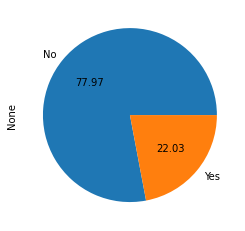

In [ ]:
pandas_df = df
pandas_df.groupby('RainTomorrow').size().plot(kind='pie', autopct='%.2f')

#### Barplot for WindDir9am

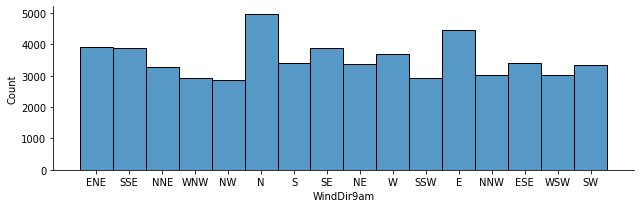

In [ ]:
import seaborn as sns
sns.displot(pandas_df['WindDir9am'], height=3, aspect=3)

#### Explain and visualize any top 5 variables using barplots /histogram or pie charts of your choice which are important in the analysis ?

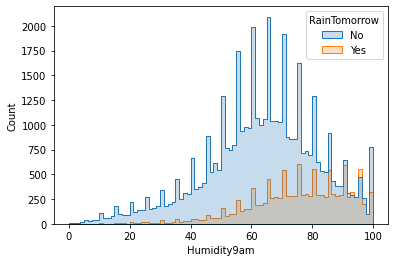

In [ ]:
#sns.barplot(pandas_df['Humidity9am'], pandas_df['Rainfall'], hue=pandas_df['RainTomorrow'])
sns.histplot(data=pandas_df, x="Humidity9am", hue="RainTomorrow", element="step")

As we can see from the graph chances of RainFall accuring tomorrow or not mostly likely to happen when humidity 9am is between 60 to 100

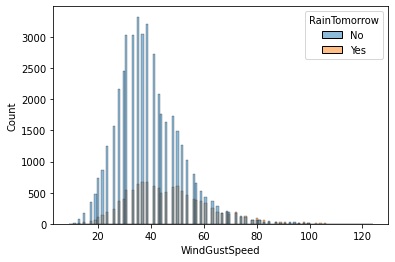

In [ ]:
sns.histplot(data=pandas_df, x="WindGustSpeed", hue="RainTomorrow")

The above graph shows that the value range of windgust speed between 30 and 80 is one of the main feature for the cause of rainfall tomorrow or not.

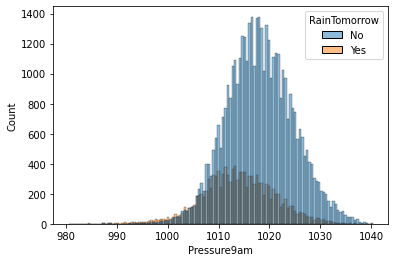

In [ ]:
sns.histplot(data=pandas_df, x="Pressure9am", hue="RainTomorrow")

Graph shows that pressure between 1000 to 1030 can cause rain fall tomorrow

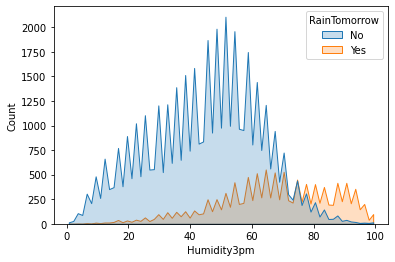

In [ ]:
sns.histplot(data=pandas_df, x="Humidity3pm", hue="RainTomorrow", element="poly")

Humidity between 60 to 100 clearly shows that high chances of rain ocurring tomorrow

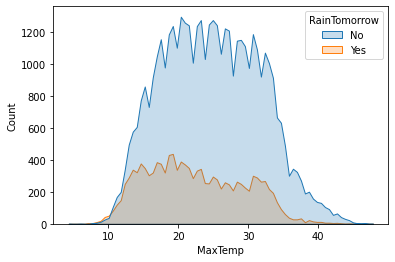

In [ ]:
sns.histplot(data=pandas_df, x="MaxTemp", hue="RainTomorrow", element="poly")

Temperature between 10 to 30 shows chances of rain tomorrow

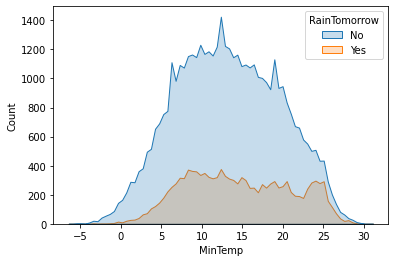

In [ ]:
sns.histplot(data=pandas_df, x="MinTemp", hue="RainTomorrow", element="poly")

Temperature between 10 to 30 shows chances of rain tomorrow

### Model Building

#### Split the data in Train and Test sets

In [ ]:
sparkDF=spark.createDataFrame(pandas_df)
#sparkDF = sparkDF.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')
categorical_columns = [c for c, t in sparkDF.dtypes if t.startswith('string')]
numerical_columns = [c for c, t in sparkDF.dtypes if t.startswith('double')]

In [ ]:
trainDF, testDF = sparkDF.randomSplit([0.8, 0.2], seed=42)
features = pandas_df.columns[0:-1]
label = pandas_df.columns[-1]

#### One hot encoding of the Categorical columns 

In [ ]:
categoricalCols = categorical_columns
 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 
 
# The label column ("RainTomorrow") is also a string value - it has two possible values, No and Yes. 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol="RainTomorrow", outputCol="label")

#### Assemble input columns in to a single vector

In [ ]:
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = numerical_columns
assemblerInputs = [c + "OHE" for c in categoricalCols if c!=label] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="feature_vec")

#### Are you going to build a regression or a classification model explain ?

I will use classification model as the prediction is to detect whether it will rain tomorrow or not. Which is a yes/no classification(binary) prediction problem.

In [ ]:
lr = LogisticRegression(featuresCol="feature_vec", labelCol="label", regParam=1.0)
dt = DecisionTreeClassifier(featuresCol="feature_vec", labelCol="label")
rf = RandomForestClassifier(featuresCol="feature_vec", labelCol="label",  maxDepth = 5,
    maxBins = 32, numTrees = 500)

In [ ]:
# Define the pipeline based on the stages created in previous steps.
pipeline_log = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])
pipeline_dt = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, dt])
pipeline_rf = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, rf])
 
# Define the pipeline model.
pipelineModel_log = pipeline_log.fit(trainDF)
pipelineModel_dt = pipeline_dt.fit(trainDF)
pipelineModel_rf = pipeline_rf.fit(trainDF)
 
# Apply the pipeline model to the test dataset.
predDF_log = pipelineModel_log.transform(testDF)
predDF_dt = pipelineModel_dt.transform(testDF)
predDF_rf = pipelineModel_rf.transform(testDF)

In [ ]:
predDF_log.select("feature_vec", "label", "prediction", "probability").show(2)

+--------------------+-----+----------+--------------------+
|         feature_vec|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(56,[12,23,32,45,...|  0.0|       0.0|[0.81946583333706...|
|(56,[4,17,32,45,4...|  0.0|       0.0|[0.87003940520460...|
+--------------------+-----+----------+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Evaluator = MulticlassClassificationEvaluator(labelCol =  'label', predictionCol = 'prediction', metricName = "accuracy")
LogReg_Accuracy = Evaluator.evaluate(predDF_log)
dt_Accuracy = Evaluator.evaluate(predDF_dt)
rf_Accuracy = Evaluator.evaluate(predDF_rf)

print('Logistic Regression Accuracy is : ' + str(LogReg_Accuracy * 100))
print('Test Error is : ' + str(1 - LogReg_Accuracy))

print('Decision Tree Accuracy is : ' + str(dt_Accuracy * 100))
print('Test Error is : ' + str(1 - dt_Accuracy))

print('Random Forest Accuracy is : ' + str(rf_Accuracy * 100))
print('Test Error is : ' + str(1 - rf_Accuracy))

Logistic Regression Accuracy is : 78.10192688636774
Test Error is : 0.21898073113632266
Decision Tree Accuracy is : 84.32378894291374
Test Error is : 0.15676211057086264
Random Forest Accuracy is : 82.82009724473258
Test Error is : 0.17179902755267418


#### CrossValidation on Logistic Regression

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
 
# Create ParamGrid for Cross Validation
paramGrid_lr = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Build out the cross validation
crossval_lr = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = Evaluator,
                          numFolds = 3)  
 
# pipelineCV = Pipeline(stages=[indexer, va, crossval])
pipeline_lr_cv = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, crossval_lr])
 
# # Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
pipelineModel_lr_cv = pipeline_lr_cv.fit(trainDF)

In [ ]:
pipelineModel_lr_cv.stages[-1].bestModel

LogisticRegressionModel: uid=LogisticRegression_84a160c83c4a, numClasses=2, numFeatures=56

#### CrossValidation Decision Tree

In [ ]:
# Build the grid of different parameters
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()
 
# Build out the cross validation
crossval_dt = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid_dt,
                          evaluator = Evaluator,
                          numFolds = 3)  
 
# pipelineCV = Pipeline(stages=[indexer, va, crossval])
pipeline_dt_cv = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, crossval_dt])
 
# # Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
pipelineModel_dt_cv = pipeline_dt_cv.fit(trainDF)

In [ ]:
pipelineModel_dt_cv.stages[-1].bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_711963f9e4c3, depth=5, numNodes=27, numClasses=2, numFeatures=56

#### CrossValidation RandomForest - work on parameters here

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid_rf = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
               .build())
 
# Create 5-fold CrossValidator
crossval_rf = CrossValidator(estimator = rf,
                      estimatorParamMaps = paramGrid_rf,
                      evaluator = Evaluator,
                      numFolds = 3)
 
# pipelineCV = Pipeline(stages=[indexer, va, crossval])
pipeline_rf_cv = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, crossval_rf])
 
# # Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
pipelineModel_rf_cv = pipeline_rf_cv.fit(trainDF)

In [ ]:
pipelineModel_rf_cv.stages[-1].bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_1c994bd4c5c9, numTrees=50, numClasses=2, numFeatures=56

#### Evaluate with confusion_matrix

In [ ]:
def confusion_matrix(preds):

  Prediction_Labels = preds.select(['prediction', 'label'])

  Matrix = MulticlassMetrics(Prediction_Labels.rdd.map(list))

  confusion_matrix = Matrix.confusionMatrix().toArray()

  print('Confusion Matrix')

  print(confusion_matrix)

  precision = (confusion_matrix[0][0]) / (confusion_matrix[0][0] + confusion_matrix[1][0])
  print('Precision = ' + str(precision))

  recall = (confusion_matrix[0][0]) / (confusion_matrix[0][0] + confusion_matrix[0][1])
  print('Recall = ' + str(recall))

  f1Score = (precision * recall) / (precision + recall) * 2
  print('F1 Score = ' + str(f1Score))

#### Evaluate Logistic Regression

In [ ]:
predDF_lr_cv = pipelineModel_lr_cv.transform(testDF)
confusion_matrix(predDF_lr_cv)

Confusion Matrix
[[8152.  501.]
 [1483.  970.]]
Precision = 0.846081992734821
Recall = 0.9421010054316422
F1 Score = 0.8915135608048994


#### Evaluate Decision tree

In [ ]:
predDF_dt_cv = pipelineModel_dt_cv.transform(testDF)
confusion_matrix(predDF_dt_cv)

Confusion Matrix
[[8312.  341.]
 [1391. 1062.]]
Precision = 0.8566422755848706
Recall = 0.9605917022997804
F1 Score = 0.9056439311396819


#### Evaluate Random Forest

In [ ]:
predDF_rf_cv = pipelineModel_rf_cv.transform(testDF)
confusion_matrix(predDF_rf_cv)

Confusion Matrix
[[8342.  311.]
 [1337. 1116.]]
Precision = 0.8618658952371113
Recall = 0.9640587079625563
F1 Score = 0.9101025529129392


So Far the best accuarcy is shown by both Random Forest and decision tree with F1 score of 90%. In this case I would prefer to use decision tree as its faster and more interpretable.

#### Feature Importance

In [ ]:
tree = pipelineModel_rf.stages[-1]
vec = pipelineModel_rf.stages[-2]

df_imp = pd.DataFrame(list(zip(vec.getInputCols(), tree.featureImportances)), columns=['Columns', 'Importance'])
df_imp.sort_values(['Importance'], ascending=False)

,Columns,Importance
12,Pressure9am,0.000582
1,WindDir9amOHE,0.000504
0,WindGustDirOHE,0.000435
13,Pressure3pm,0.000382
3,RainTodayOHE,0.000349
2,WindDir3pmOHE,0.000197
4,MinTemp,0.000159
11,Humidity3pm,0.000149
8,WindSpeed9am,0.000131
9,WindSpeed3pm,0.000129
